In [1]:
import math

def estimate_slurm_resources(sim, n_inhom: int, n_times: int, n_batches: int) -> tuple[str, str]:
    """Estimate SLURM memory and time requirements based on workload."""
    combos = n_times * n_inhom
    num_combos_per_batch = combos // n_batches
    workers = sim.simulation_config.max_workers # should be 16
    # Estimate memory: base 1G + factor for data size (complex64 = 8 bytes)
    len_t = len(sim.times_global) # NOTE actually it saves only a portion of this len: t_det up to time_cut
    mem_mb = 2000 + 10 * (workers * len_t * 8) / (1024**2)  # 10 is a safety factor
    requested_mem_mb = int(math.ceil(mem_mb))
    requested_mem = f"{requested_mem_mb}M"
    
    # Estimate time: scale based on solver, n_atoms, len_coh_times
    solver = sim.simulation_config.ode_solver
    n_atoms = sim.system.n_atoms
    base_time_per_combo_seconds = 1  # normalized from example: 1 combo in 3s for ME with 1 atom, 1 t_coh value for len_t = 1000
    if solver == "BR":
        base_time_per_combo_seconds = 2.5  # for len_t=1000, 1 combo, 1 atom, 1 t_coh
    base_time_per_combo_seconds *= n_atoms ** 2  # quadratic scaling with n_atoms (matrix diagonalization)
    base_time_per_combo_seconds *= len_t / 1000  # scaling with detection time length
    time_seconds = num_combos_per_batch * base_time_per_combo_seconds
    time_hours = max(0.1, time_seconds / 3600)  # minimum ~36 seconds for safety
    if time_hours < 1:
        minutes = int(time_hours * 60)
        requested_time = f"00:{minutes:02d}:00"
    else:
        days = int(time_hours) // 24
        hours = int(time_hours) % 24
        if days > 0:
            requested_time = f"{days}-{hours:02d}:00:00"
        else:
            requested_time = f"{hours:02d}:00:00"
    
    return requested_mem, requested_time

In [2]:
# Mock simulation object for testing
class MockSim:
    def __init__(self, ode_solver, n_atoms, len_t=1000):
        self.simulation_config = type('obj', (object,), {'ode_solver': ode_solver, 'max_workers': 16})
        self.system = type('obj', (object,), {'n_atoms': n_atoms})
        self.times_global = [0] * len_t  # mock times_global array

In [6]:
test_cases = [
    ('Currently i want to simulate: 2D (n_times=600) ME, 1 atom, length of times approx 1000', MockSim(ode_solver="ME", n_atoms=1, len_t=1000), 50, 600, 72),
]

In [7]:
# Run tests
print("SLURM Resource Estimation Test Results")
print("=" * 60)
for desc, sim, n_inhom, n_times, n_batches in test_cases:
    mem, time = estimate_slurm_resources(sim, n_inhom, n_times, n_batches)
    combos = n_times * n_inhom
    combos_per_batch = combos // n_batches
    print(f"{desc}:")
    print(f"  Total combos: {combos}, Combos/batch: {combos_per_batch}, N_inhom: {n_inhom}, N_times: {n_times}, N_batches: {n_batches}")
    print(f"  Solver: {sim.simulation_config.ode_solver}, N_atoms: {sim.system.n_atoms}")
    print(f"  Estimated Memory: {mem}, Time: {time}")
    print()

SLURM Resource Estimation Test Results
Currently i want to simulate: 2D (n_times=600) ME, 1 atom, length of times approx 1000:
  Total combos: 30000, Combos/batch: 416, N_inhom: 50, N_times: 600, N_batches: 72
  Solver: ME, N_atoms: 1
  Estimated Memory: 2002M, Time: 00:06:00



In [22]:
import math

def parse_time_to_seconds(time_str: str) -> float:
    """Parse SLURM time string to seconds."""
    if '-' in time_str:
        days, rest = time_str.split('-')
        days = int(days)
        h, m, s = map(int, rest.split(':'))
    else:
        days = 0
        h, m, s = map(int, time_str.split(':'))
    return days * 86400 + h * 3600 + m * 60 + s

def find_optimal_n_batches(sim, n_inhom: int, n_times: int) -> tuple[int, float]:
    """Find the optimal number of batches to minimize total time, considering max 4 parallel jobs."""
    combos = n_times * n_inhom
    min_total_time = float('inf')
    best_n_batches = None
    
    # Loop over possible n_batches (limit to reasonable range for performance)
    max_batches = min(combos, 1000)  # Cap at 1000 to avoid long loops
    for n_batches in range(1, max_batches + 1):
        mem, time_str = estimate_slurm_resources(sim, n_inhom, n_times, n_batches)
        time_per_batch = parse_time_to_seconds(time_str)
        parallel_groups = math.ceil(n_batches / 4)
        total_time = parallel_groups * time_per_batch
        if total_time < min_total_time:
            min_total_time = total_time
            best_n_batches = n_batches
    
    return best_n_batches, min_total_time

# Test the optimal finder
print("Finding optimal n_batches...")
optimal_batches, min_time_seconds = find_optimal_n_batches(test_cases[0][1], 100, 600)
print(f"Optimal n_batches: {optimal_batches}")
print(f"Minimal total time: {min_time_seconds / 3600:.2f} hours")

Finding optimal n_batches...
Optimal n_batches: 9
Minimal total time: 3.00 hours


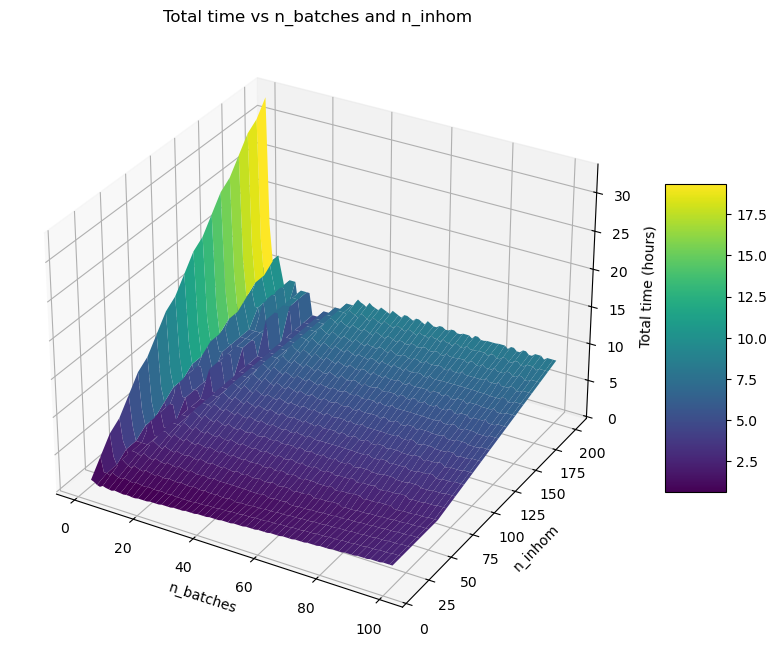

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define ranges
n_inhom_range = np.arange(10, 201, 10)  # 10 to 200, step 10
n_batches_range = np.arange(1, 101, 1)  # 1 to 100
n_times = 600
sim = test_cases[0][1]

# Initialize Z array
Z = np.zeros((len(n_inhom_range), len(n_batches_range)))

# Compute total time for each combination
for i, n_inhom in enumerate(n_inhom_range):
    combos = n_times * n_inhom
    max_n_batches = min(combos, 1000)
    for j, n_batches in enumerate(n_batches_range):
        if n_batches > max_n_batches:
            Z[i, j] = np.nan  # or skip
            continue
        mem, time_str = estimate_slurm_resources(sim, n_inhom, n_times, n_batches)
        time_per_batch = parse_time_to_seconds(time_str)
        parallel_groups = math.ceil(n_batches / 4)
        total_time = parallel_groups * time_per_batch
        Z[i, j] = total_time / 3600  # convert to hours

# Create meshgrid
X, Y = np.meshgrid(n_batches_range, n_inhom_range)

# Plot 3D surface
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
ax.set_xlabel('n_batches')
ax.set_ylabel('n_inhom')
ax.set_zlabel('Total time (hours)')
ax.set_title('Total time vs n_batches and n_inhom')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
plt.show()